# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [96]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [97]:

!pip install gymnasium numpy matplotlib scikit-learn joblib pygame

state vector dim = 4
n_actions = 2


c:\Users\lutdi\miniconda3\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


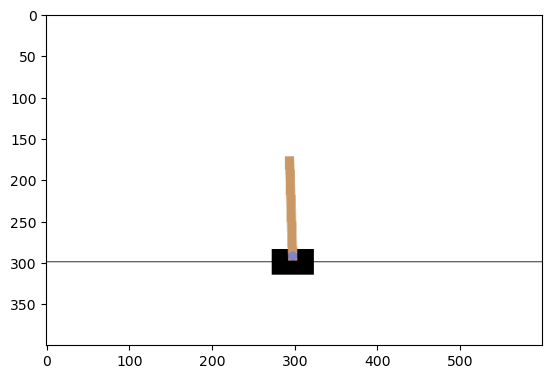

In [98]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [99]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    activation='relu',
    solver='adam',
    batch_size=64,
    learning_rate_init=0.001,
    max_iter=1,             
    random_state=42
)

initial_state = env.reset()[0]
agent.partial_fit([initial_state], [0], classes=range(n_actions))

c:\Users\lutdi\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


,hidden_layer_sizes,"(64, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,64
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1
,shuffle,True
,random_state,42


In [100]:
def generate_session(env, agent, t_max=1000):
    states, actions = [], []
    total_reward = 0
    s, _ = env.reset()
    for t in range(t_max):

        probs = agent.predict_proba([s])[0]  
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector"

        a = np.random.choice(env.action_space.n, p=probs)  
        
        new_s, r, terminated, truncated, _ = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

In [101]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[ 0.03772549 -0.03542635  0.04139904  0.04034049]
 [ 0.03701697  0.15907824  0.04220585 -0.23899858]
 [ 0.04019853  0.35357264  0.03742588 -0.5180755 ]
 [ 0.04726998  0.5481482   0.02706437 -0.7987339 ]
 [ 0.05823295  0.35266563  0.01108969 -0.4976614 ]]
actions: [1, 1, 1, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [102]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    threshold = np.percentile(rewards_batch, percentile)
    elite_indices = [i for i, r in enumerate(rewards_batch) if r > threshold]
    elite_states = [s for i in elite_indices for s in states_batch[i]]
    elite_actions = [a for i in elite_indices for a in actions_batch[i]]
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def show_progress(rewards_batch, log, percentile, reward_range=[0, 200]):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))

    current_min, current_max = np.min(rewards_batch), np.max(rewards_batch)
    if current_min == current_max:
        current_max = current_min + 1e-6  

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=(current_min, current_max))
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    plt.show()



mean reward = 24.600, threshold=31.000


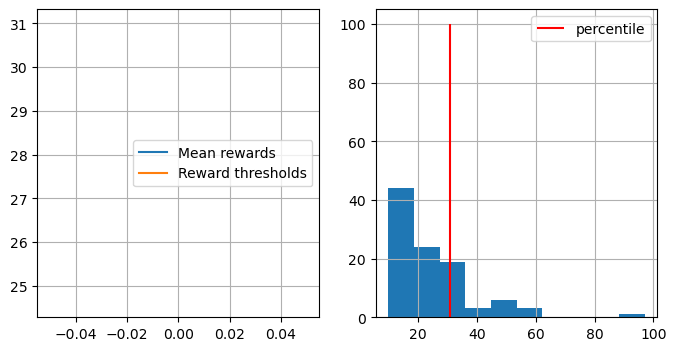

mean reward = 26.400, threshold=32.250


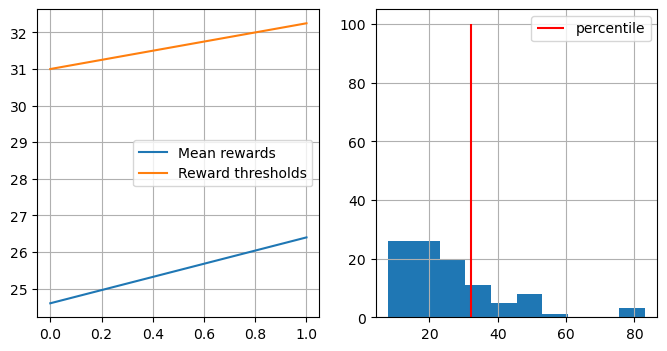

mean reward = 31.530, threshold=39.000


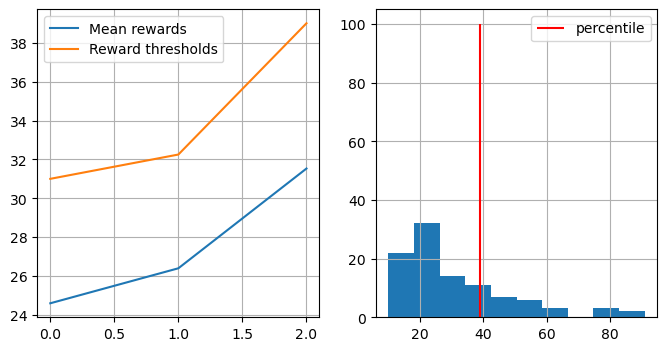

mean reward = 35.750, threshold=45.250


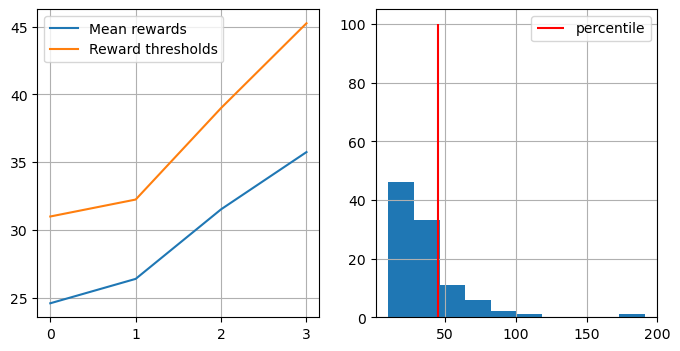

mean reward = 34.330, threshold=44.000


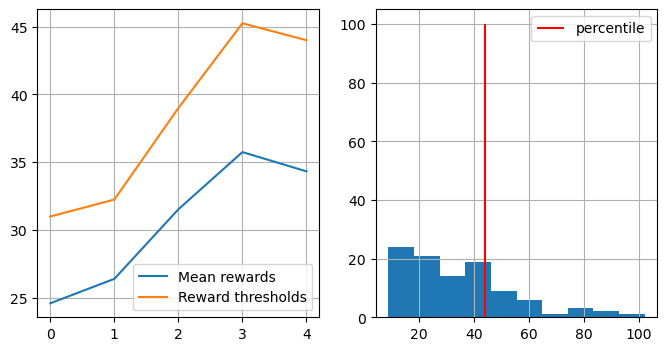

mean reward = 44.470, threshold=56.000


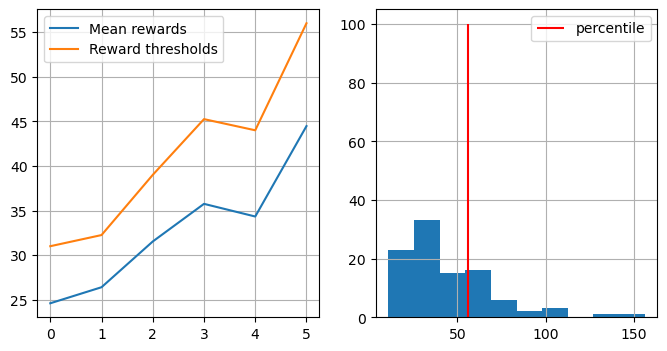

mean reward = 46.410, threshold=63.000


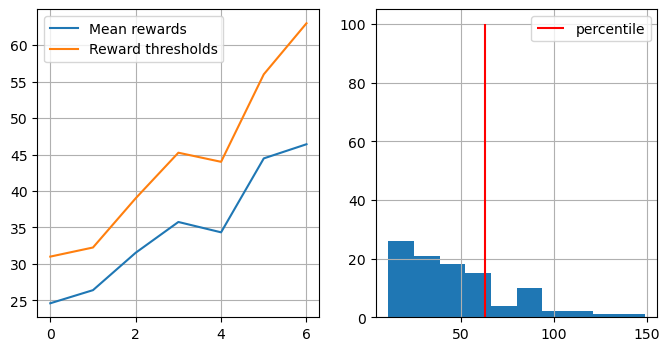

mean reward = 50.810, threshold=65.750


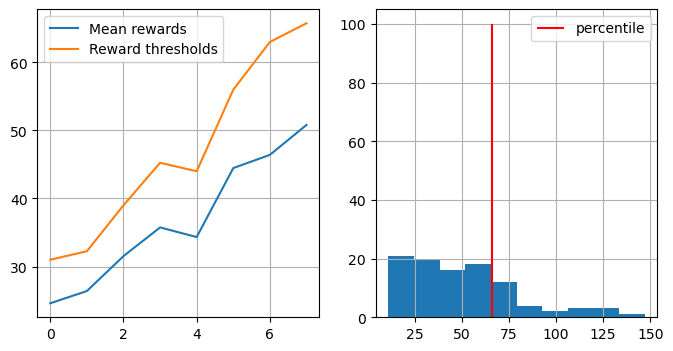

mean reward = 64.050, threshold=83.000


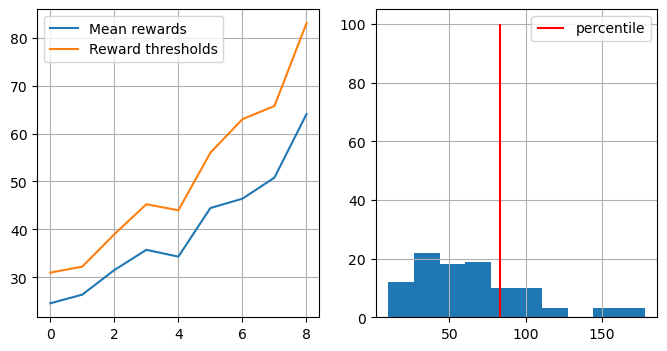

mean reward = 86.230, threshold=106.000


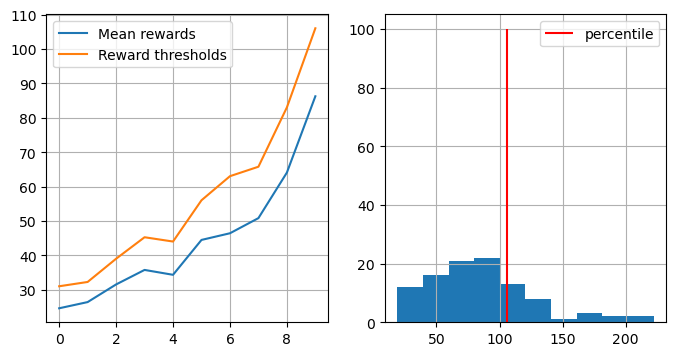

mean reward = 100.050, threshold=130.000


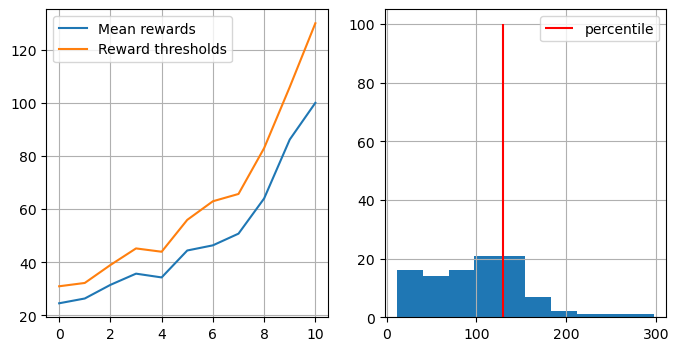

mean reward = 118.200, threshold=144.250


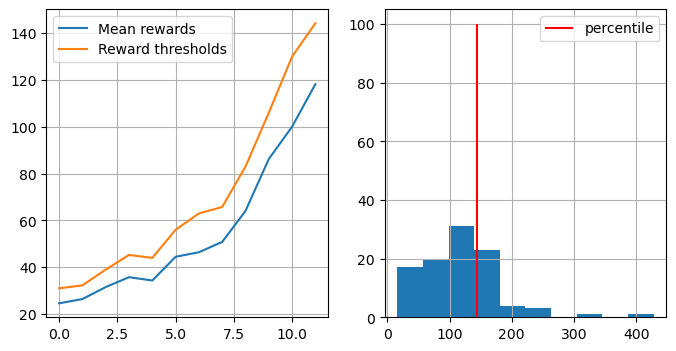

mean reward = 154.970, threshold=185.000


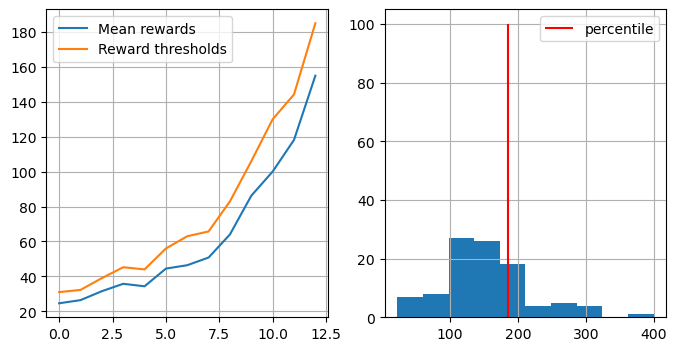

mean reward = 197.030, threshold=241.500


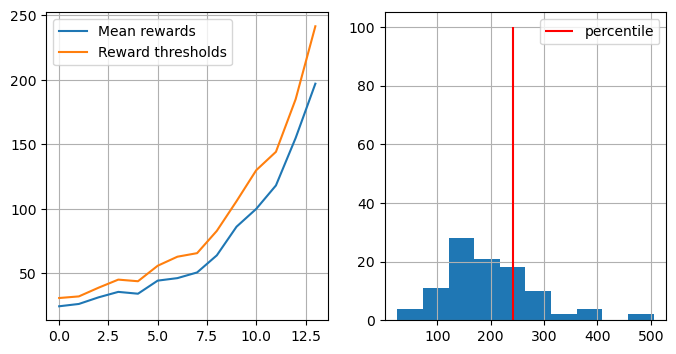

You Win! You may stop training now via KeyboardInterrupt.
mean reward = 202.910, threshold=246.500


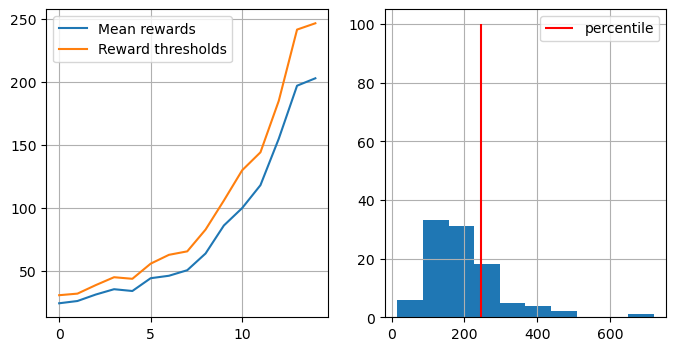

You Win! You may stop training now via KeyboardInterrupt.
mean reward = 246.930, threshold=315.500


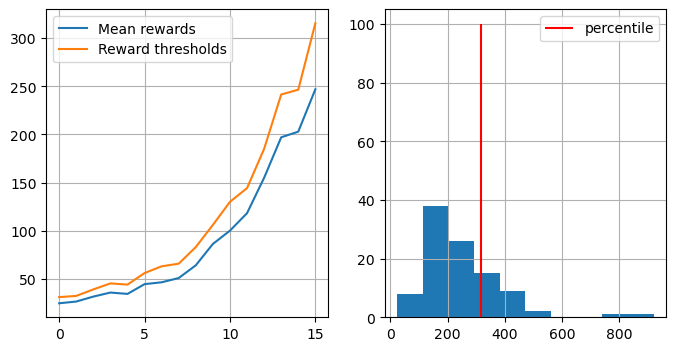

You Win! You may stop training now via KeyboardInterrupt.
mean reward = 377.810, threshold=490.000


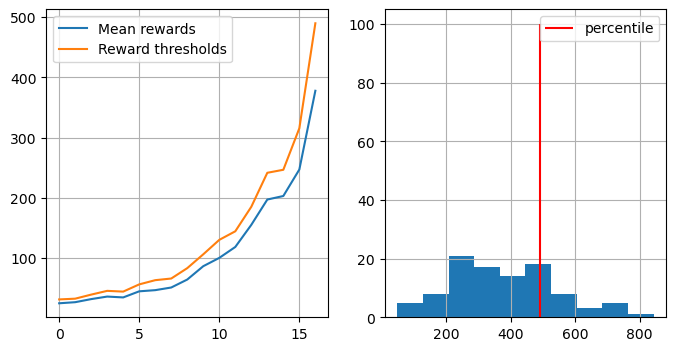

You Win! You may stop training now via KeyboardInterrupt.
mean reward = 382.160, threshold=450.750


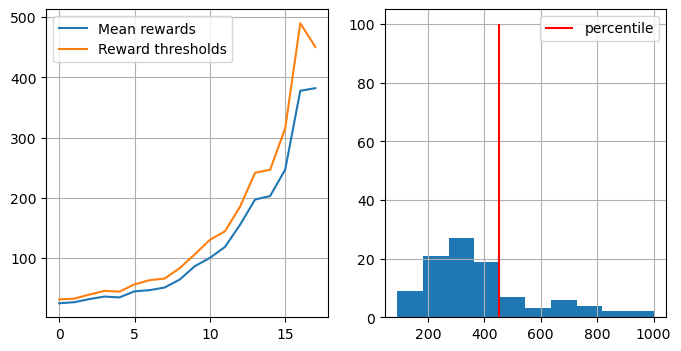

You Win! You may stop training now via KeyboardInterrupt.
mean reward = 517.220, threshold=624.750


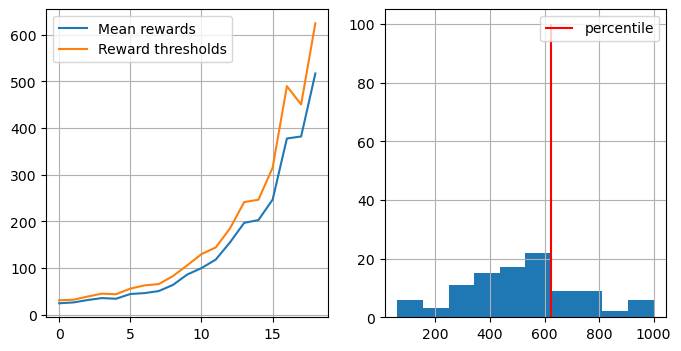

You Win! You may stop training now via KeyboardInterrupt.
mean reward = 614.210, threshold=932.750


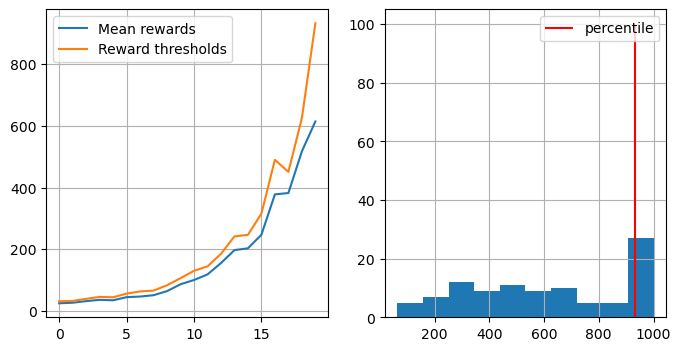

You Win! You may stop training now via KeyboardInterrupt.
No elite samples this iteration. Skipping training.
mean reward = 744.350, threshold=1000.000


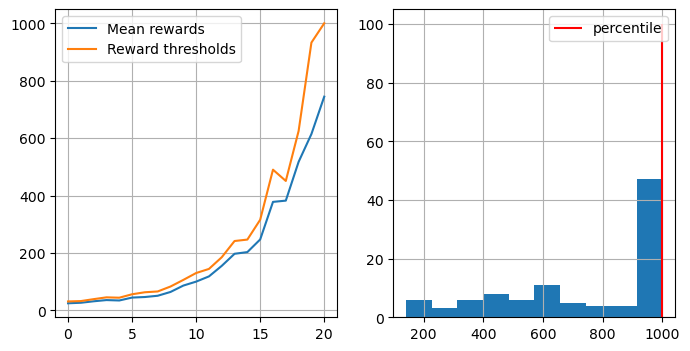

No elite samples this iteration. Skipping training.
mean reward = 714.960, threshold=1000.000


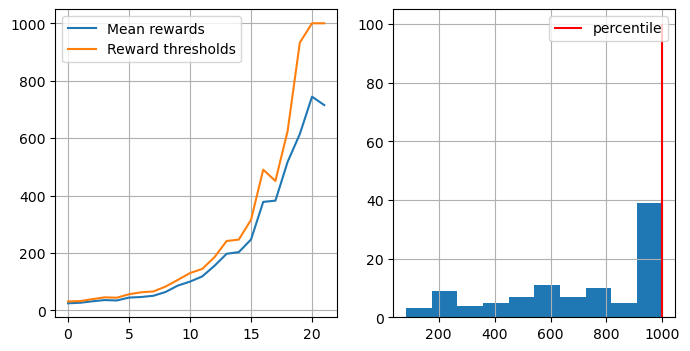

No elite samples this iteration. Skipping training.
mean reward = 736.490, threshold=1000.000


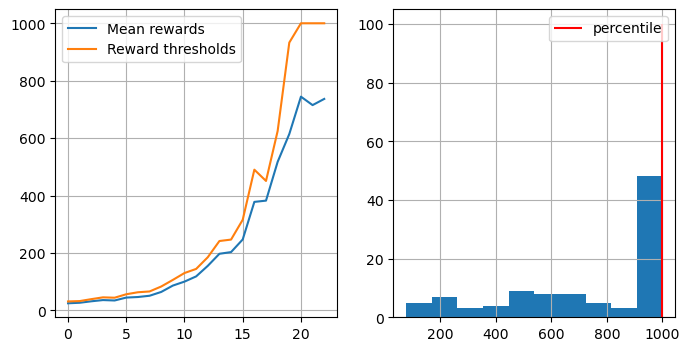

No elite samples this iteration. Skipping training.
mean reward = 703.360, threshold=1000.000


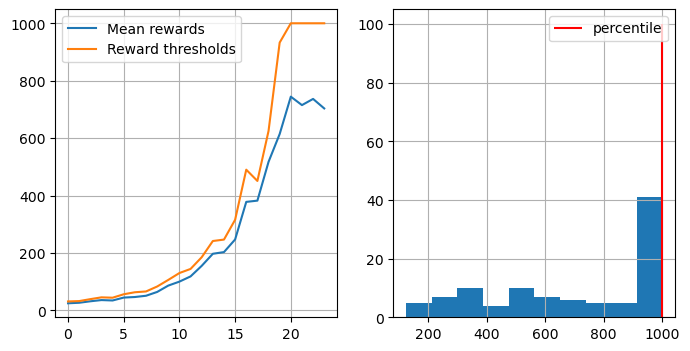

No elite samples this iteration. Skipping training.
mean reward = 727.120, threshold=1000.000


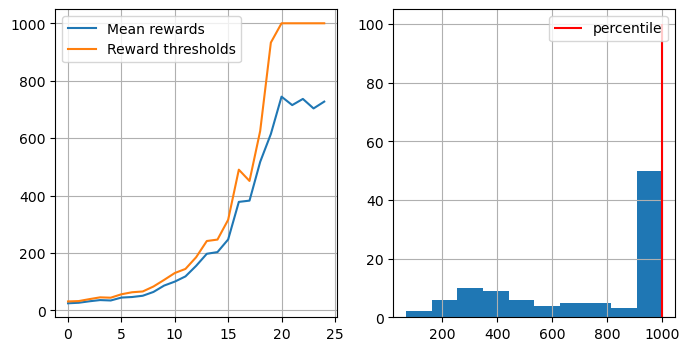

No elite samples this iteration. Skipping training.
mean reward = 682.920, threshold=1000.000


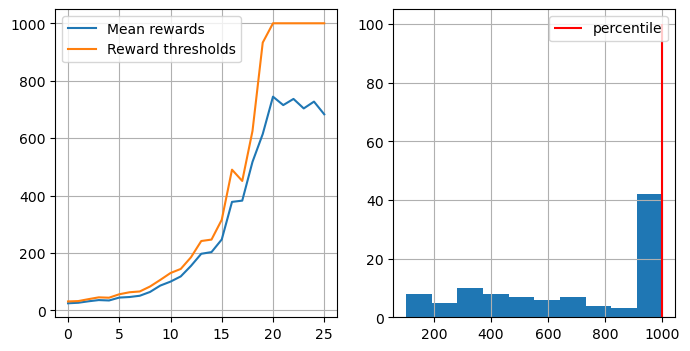

No elite samples this iteration. Skipping training.
mean reward = 665.010, threshold=1000.000


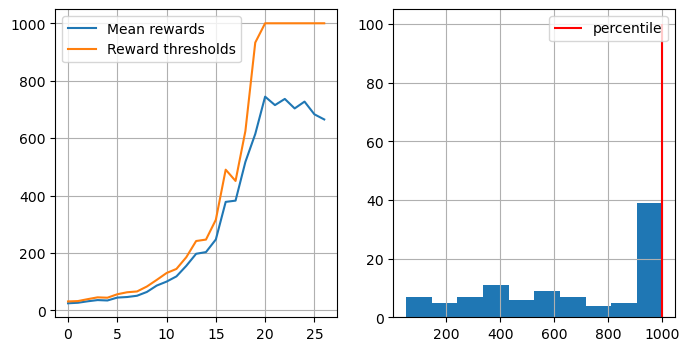

No elite samples this iteration. Skipping training.
mean reward = 750.530, threshold=1000.000


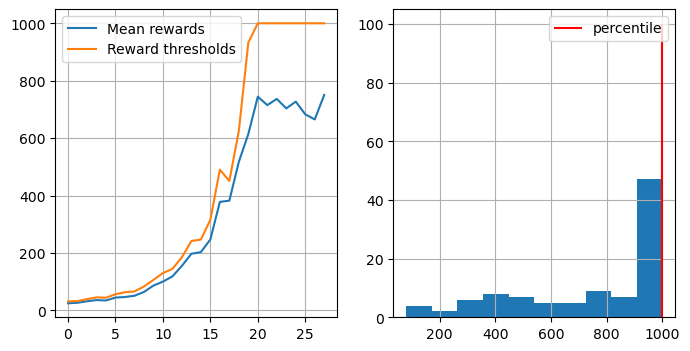

No elite samples this iteration. Skipping training.
mean reward = 699.180, threshold=1000.000


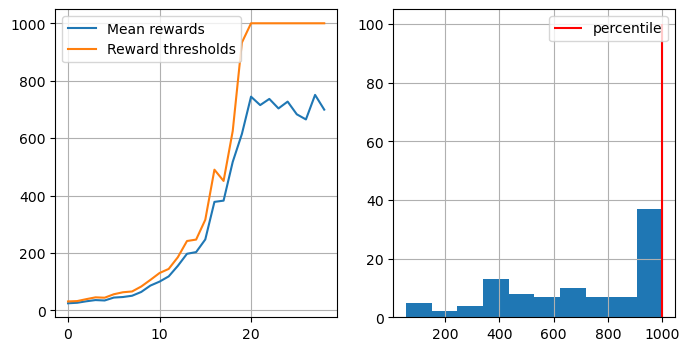

No elite samples this iteration. Skipping training.
mean reward = 694.040, threshold=1000.000


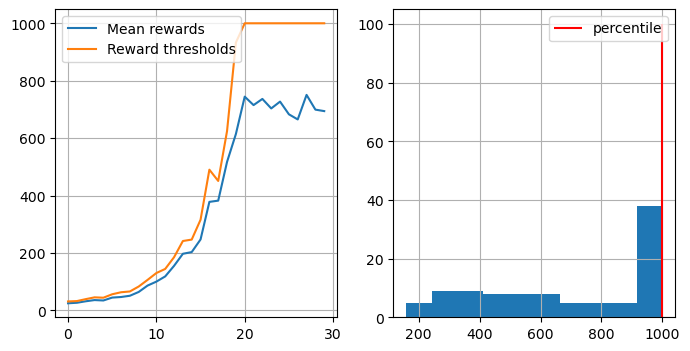

No elite samples this iteration. Skipping training.
mean reward = 745.170, threshold=1000.000


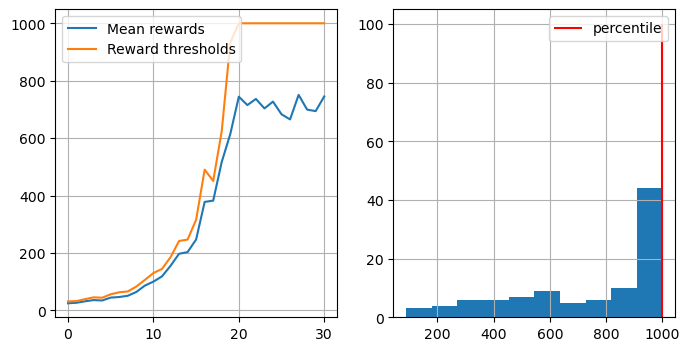

No elite samples this iteration. Skipping training.
mean reward = 717.350, threshold=1000.000


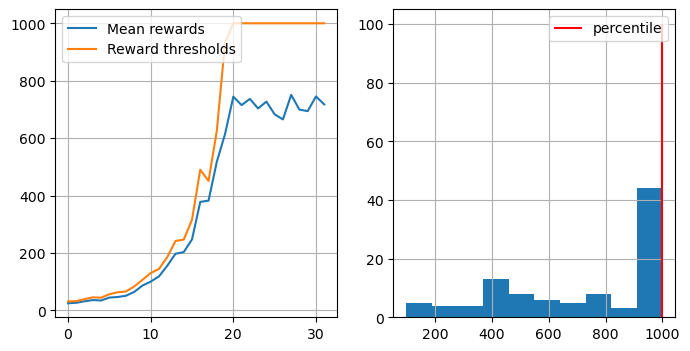

No elite samples this iteration. Skipping training.
mean reward = 736.580, threshold=1000.000


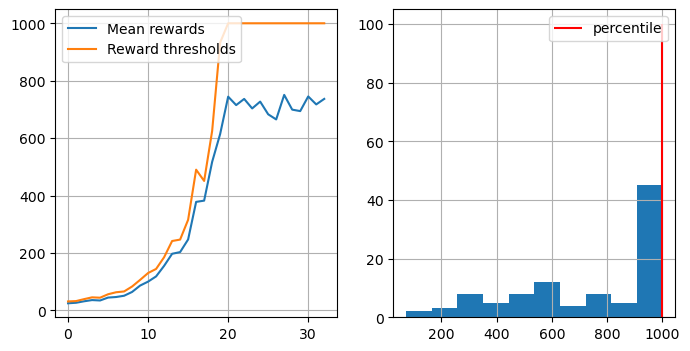

No elite samples this iteration. Skipping training.
mean reward = 703.900, threshold=1000.000


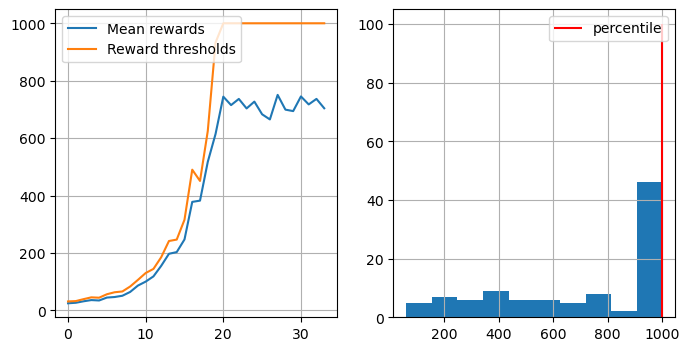

No elite samples this iteration. Skipping training.
mean reward = 748.850, threshold=1000.000


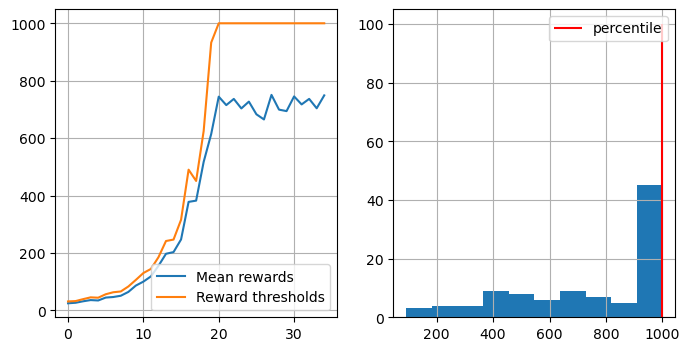

No elite samples this iteration. Skipping training.
mean reward = 738.690, threshold=1000.000


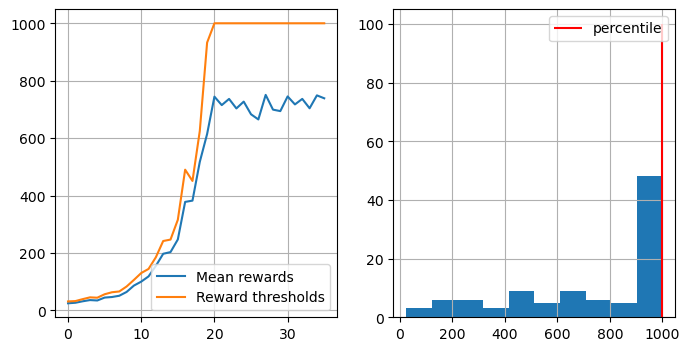

No elite samples this iteration. Skipping training.
mean reward = 701.930, threshold=1000.000


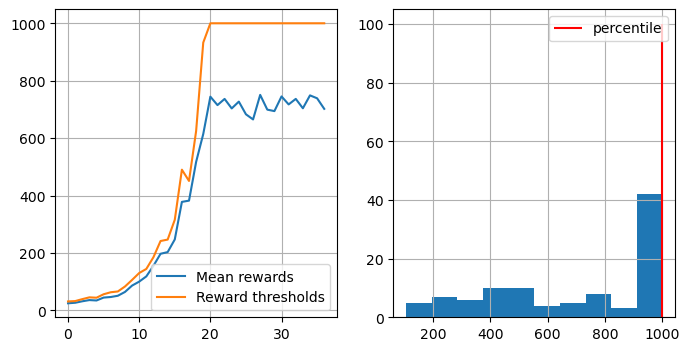

No elite samples this iteration. Skipping training.
mean reward = 715.470, threshold=1000.000


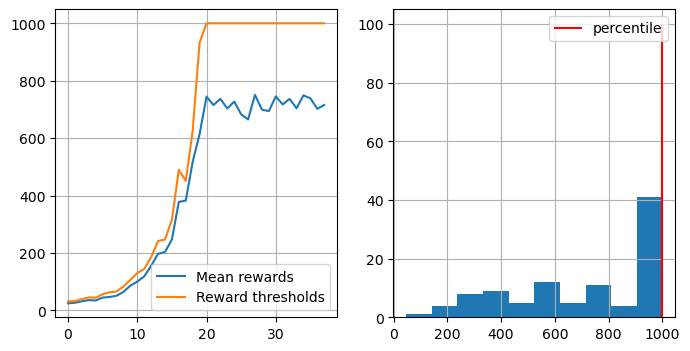

No elite samples this iteration. Skipping training.
mean reward = 679.640, threshold=1000.000


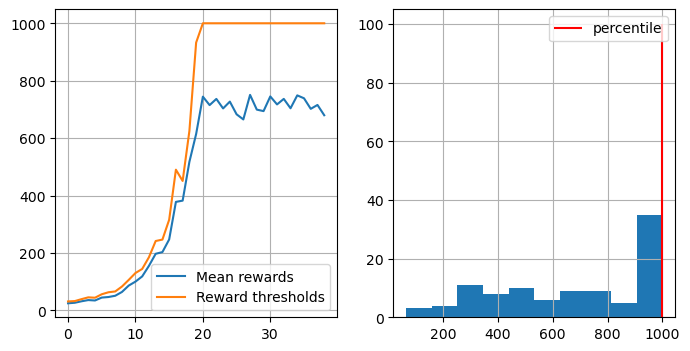

No elite samples this iteration. Skipping training.
mean reward = 730.690, threshold=1000.000


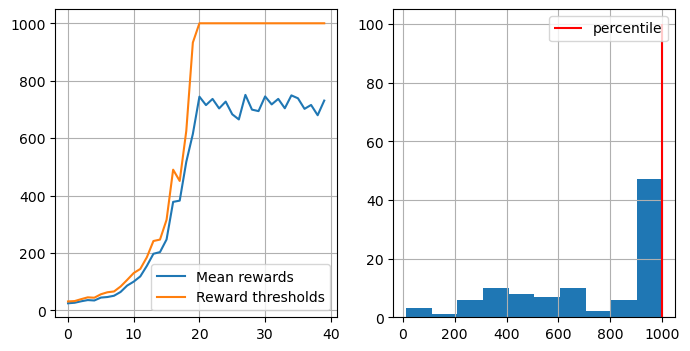

No elite samples this iteration. Skipping training.
mean reward = 683.270, threshold=1000.000


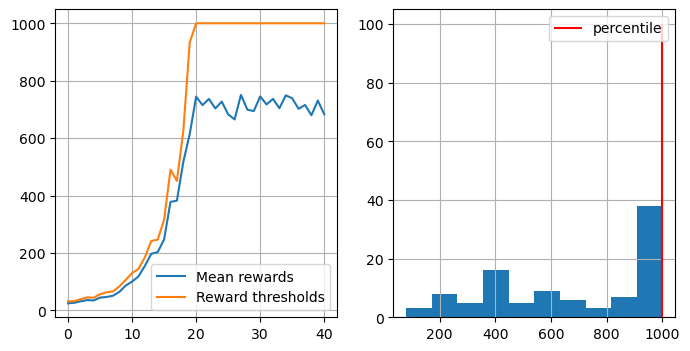

No elite samples this iteration. Skipping training.
mean reward = 714.600, threshold=1000.000


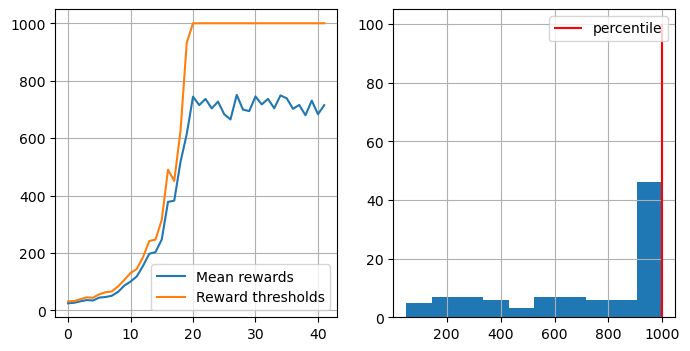

No elite samples this iteration. Skipping training.
mean reward = 763.480, threshold=1000.000


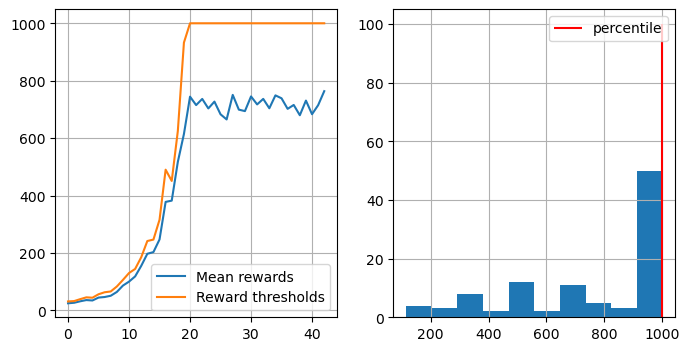

No elite samples this iteration. Skipping training.
mean reward = 718.910, threshold=1000.000


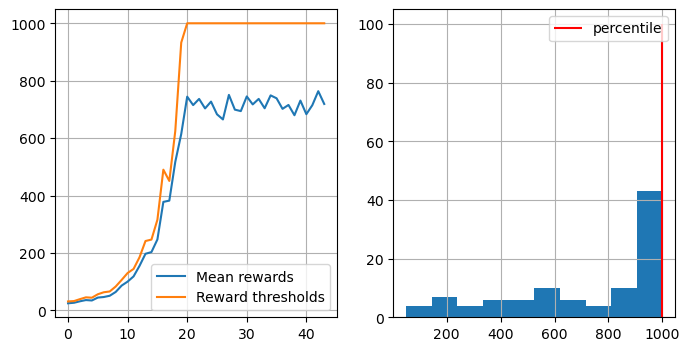

No elite samples this iteration. Skipping training.
mean reward = 669.510, threshold=1000.000


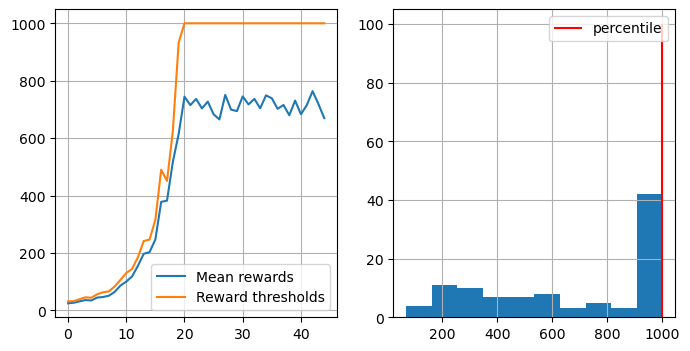

No elite samples this iteration. Skipping training.
mean reward = 746.810, threshold=1000.000


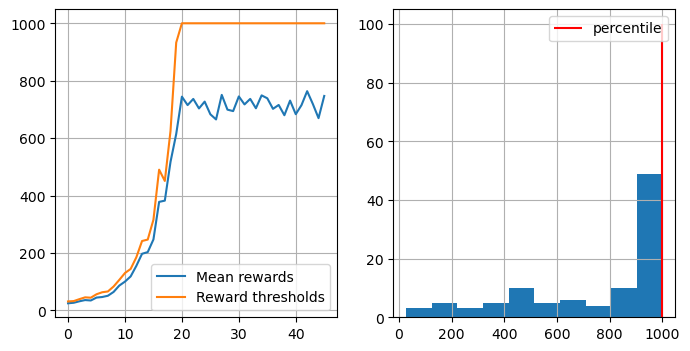

No elite samples this iteration. Skipping training.
mean reward = 713.040, threshold=1000.000


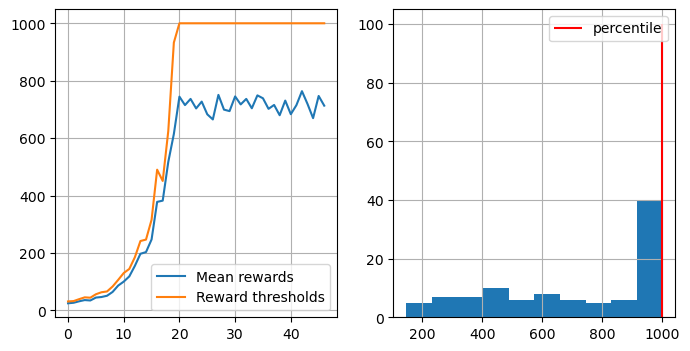

No elite samples this iteration. Skipping training.
mean reward = 707.500, threshold=1000.000


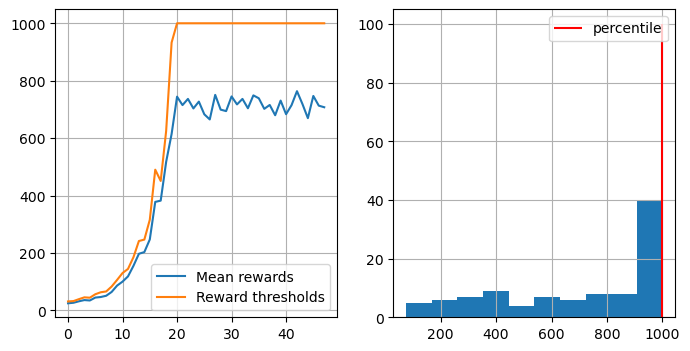

No elite samples this iteration. Skipping training.
mean reward = 742.680, threshold=1000.000


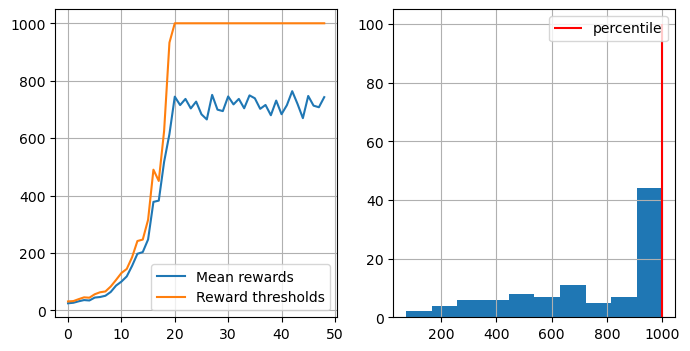

No elite samples this iteration. Skipping training.
mean reward = 683.640, threshold=1000.000


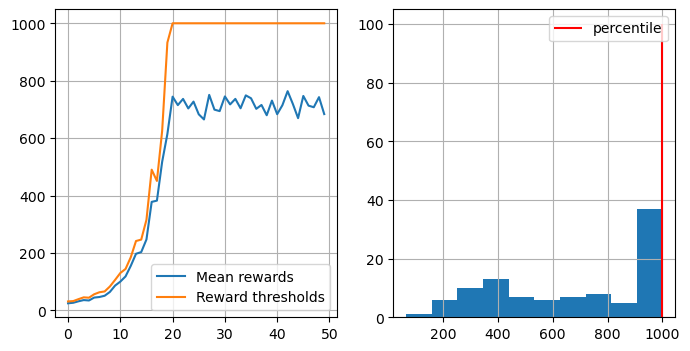

No elite samples this iteration. Skipping training.
mean reward = 693.820, threshold=1000.000


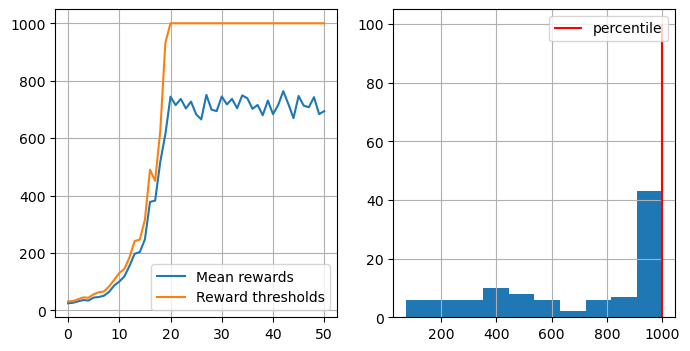

No elite samples this iteration. Skipping training.
mean reward = 686.300, threshold=1000.000


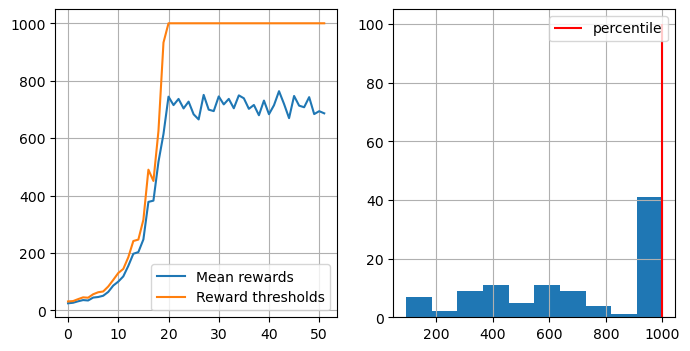

No elite samples this iteration. Skipping training.
mean reward = 734.630, threshold=1000.000


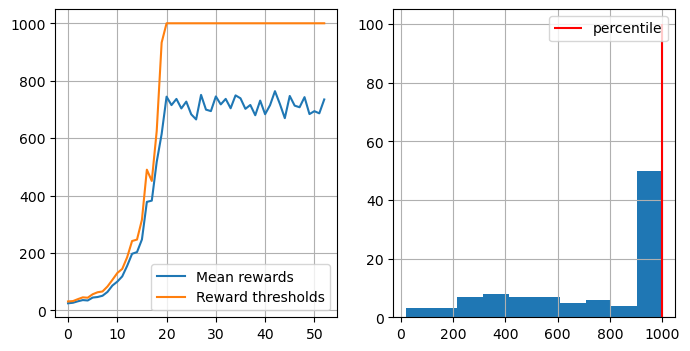

No elite samples this iteration. Skipping training.
mean reward = 711.200, threshold=1000.000


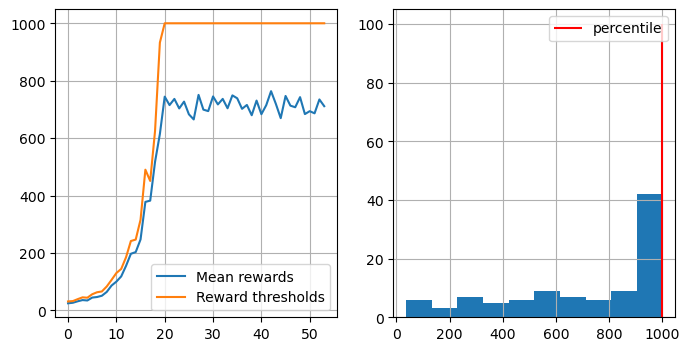

No elite samples this iteration. Skipping training.
mean reward = 730.100, threshold=1000.000


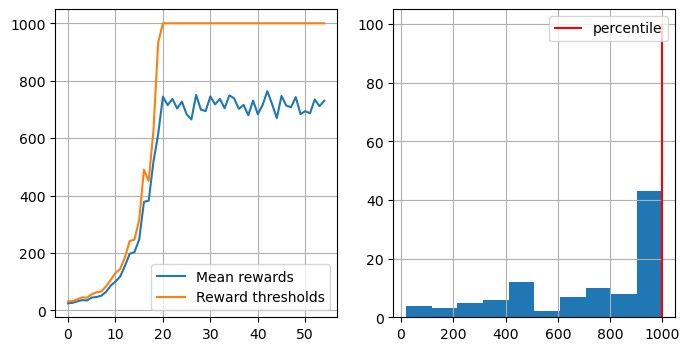

No elite samples this iteration. Skipping training.
mean reward = 745.010, threshold=1000.000


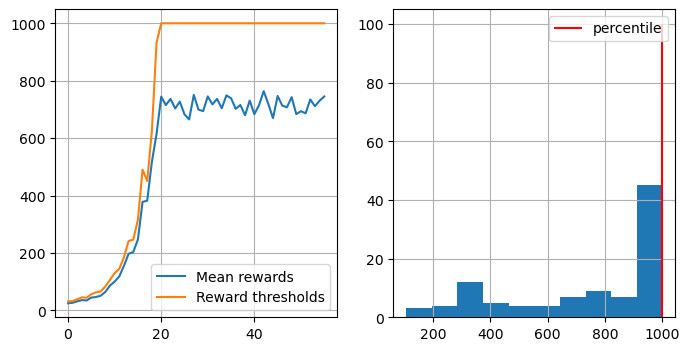

No elite samples this iteration. Skipping training.
mean reward = 667.420, threshold=1000.000


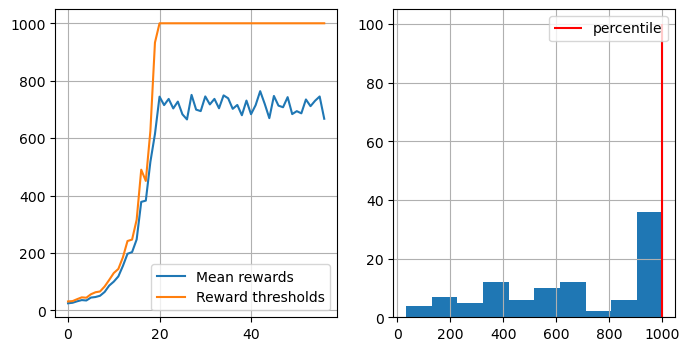

No elite samples this iteration. Skipping training.
mean reward = 695.480, threshold=1000.000


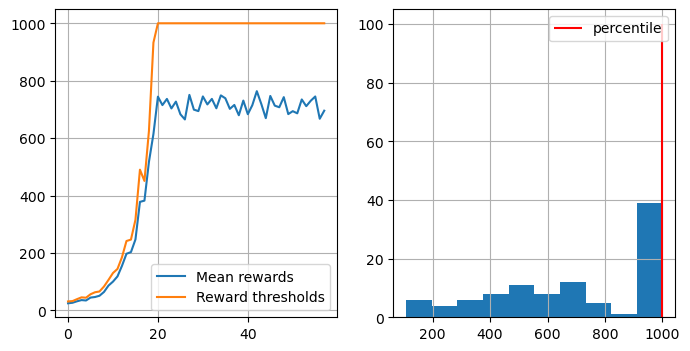

No elite samples this iteration. Skipping training.
mean reward = 636.370, threshold=1000.000


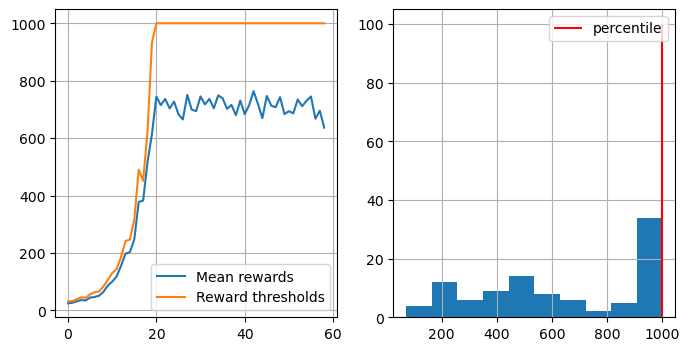

No elite samples this iteration. Skipping training.
mean reward = 737.310, threshold=1000.000


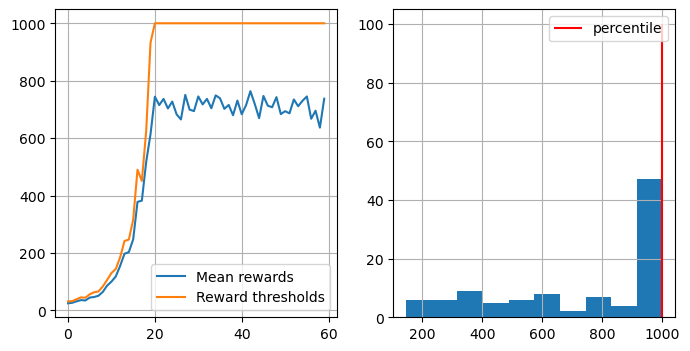

No elite samples this iteration. Skipping training.
mean reward = 756.230, threshold=1000.000


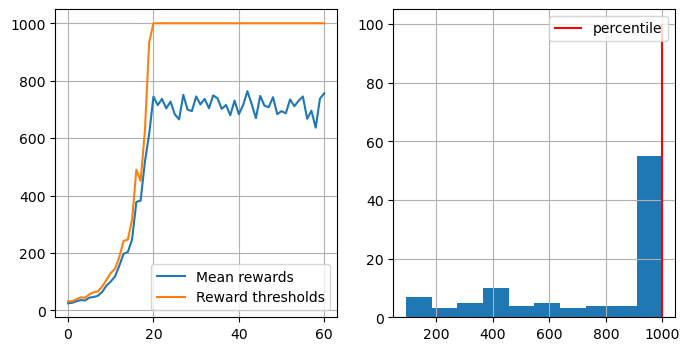

No elite samples this iteration. Skipping training.
mean reward = 739.120, threshold=1000.000


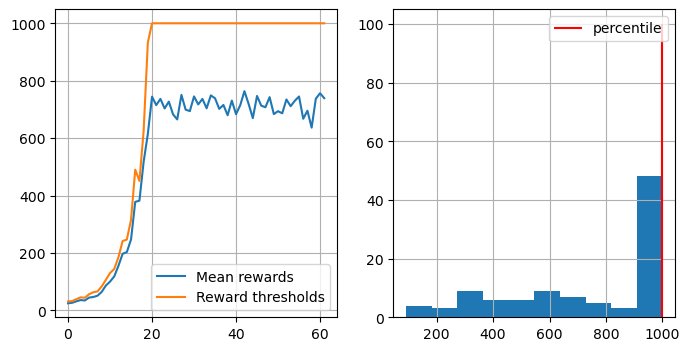

No elite samples this iteration. Skipping training.
mean reward = 724.790, threshold=1000.000


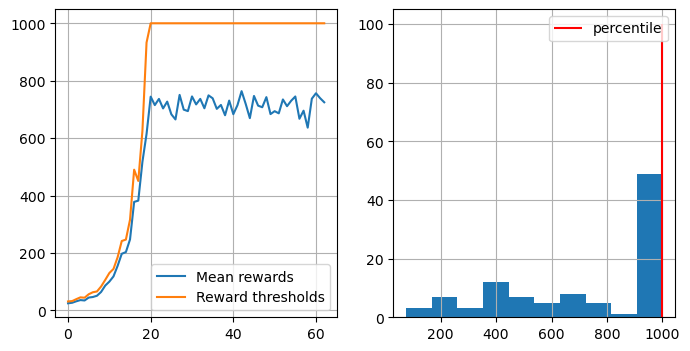

No elite samples this iteration. Skipping training.
mean reward = 774.360, threshold=1000.000


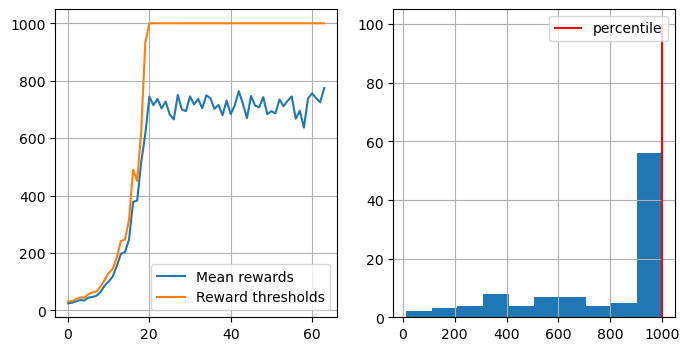

No elite samples this iteration. Skipping training.
mean reward = 749.020, threshold=1000.000


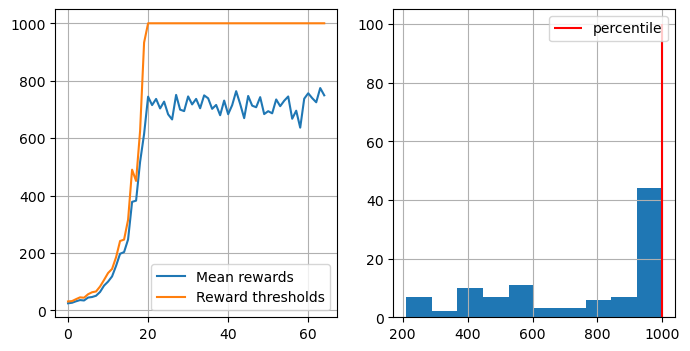

No elite samples this iteration. Skipping training.
mean reward = 681.660, threshold=1000.000


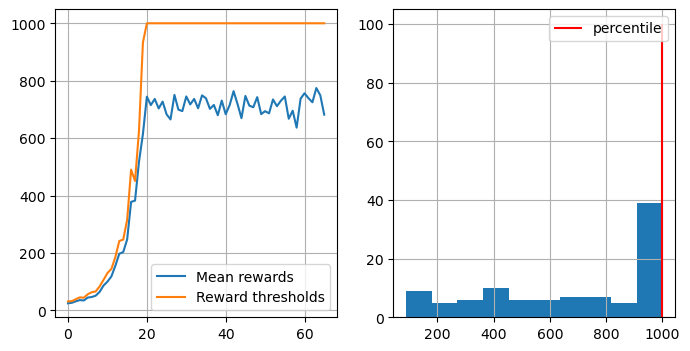

No elite samples this iteration. Skipping training.
mean reward = 759.330, threshold=1000.000


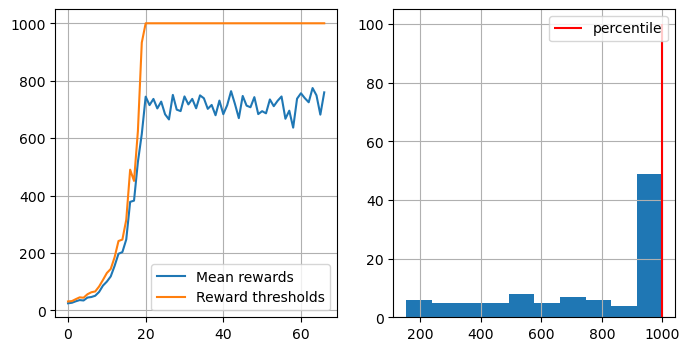

No elite samples this iteration. Skipping training.
mean reward = 698.730, threshold=1000.000


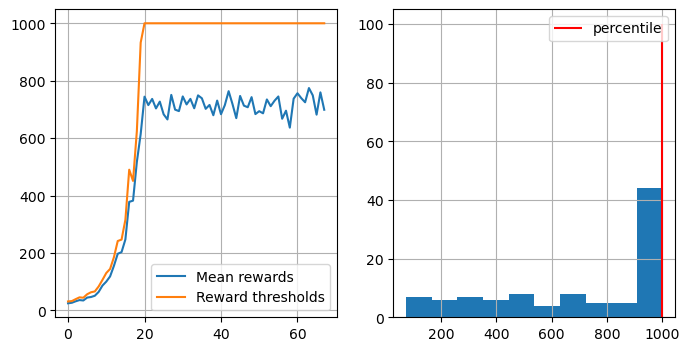

No elite samples this iteration. Skipping training.
mean reward = 691.800, threshold=1000.000


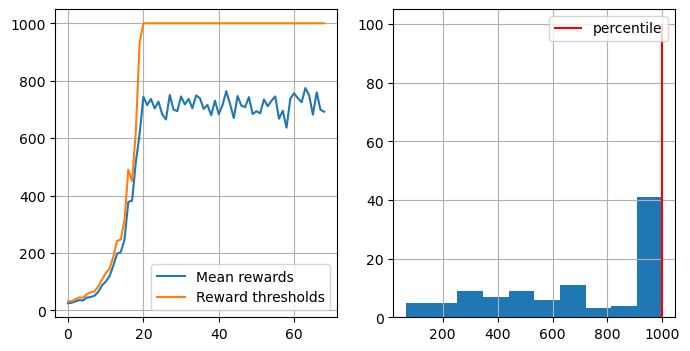

No elite samples this iteration. Skipping training.
mean reward = 706.030, threshold=1000.000


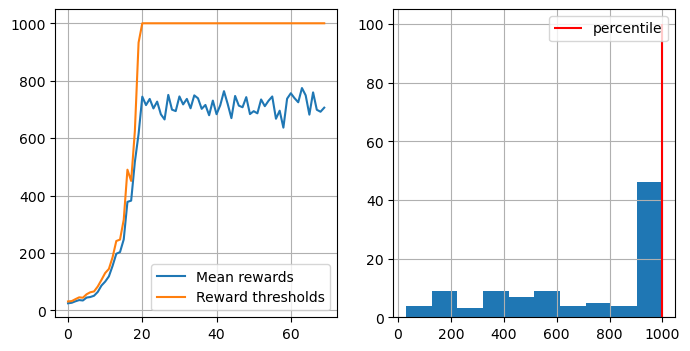

No elite samples this iteration. Skipping training.
mean reward = 735.580, threshold=1000.000


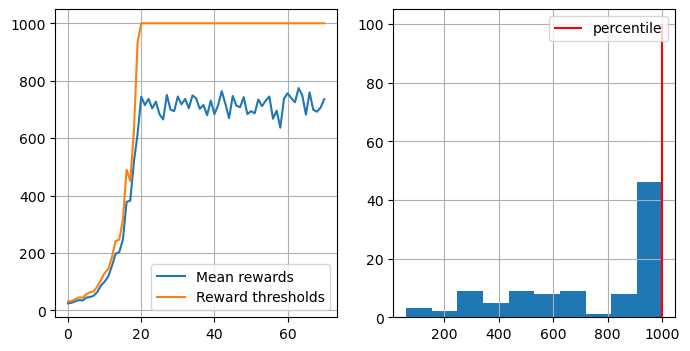

No elite samples this iteration. Skipping training.
mean reward = 696.930, threshold=1000.000


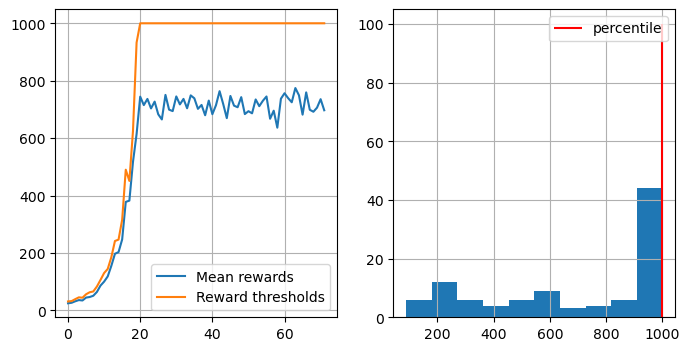

No elite samples this iteration. Skipping training.
mean reward = 727.400, threshold=1000.000


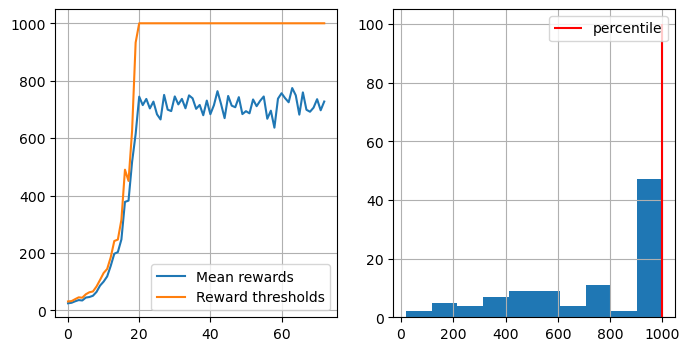

No elite samples this iteration. Skipping training.
mean reward = 670.280, threshold=1000.000


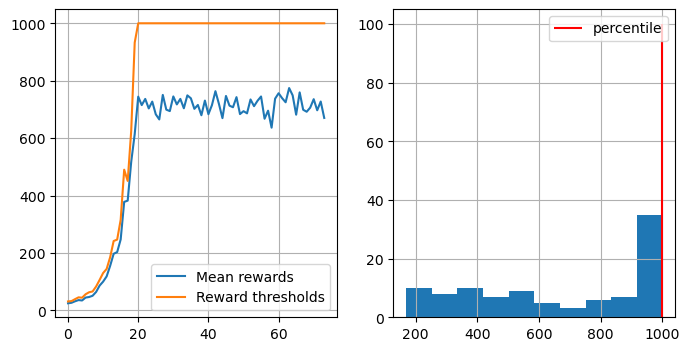

No elite samples this iteration. Skipping training.
mean reward = 691.980, threshold=1000.000


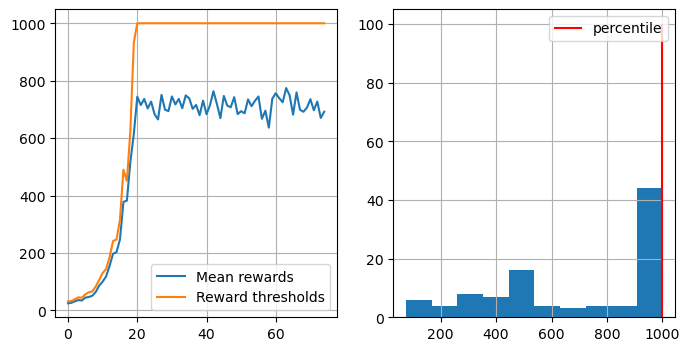

No elite samples this iteration. Skipping training.
mean reward = 735.100, threshold=1000.000


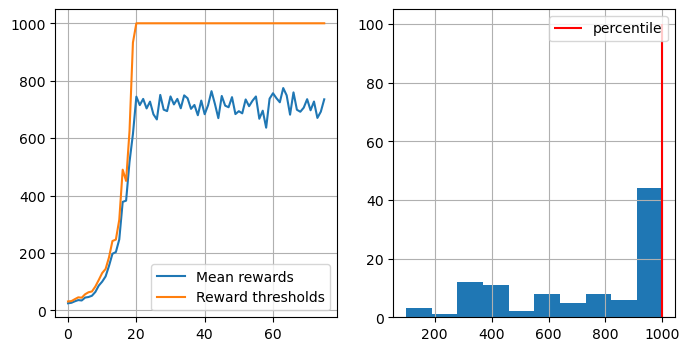

No elite samples this iteration. Skipping training.
mean reward = 722.170, threshold=1000.000


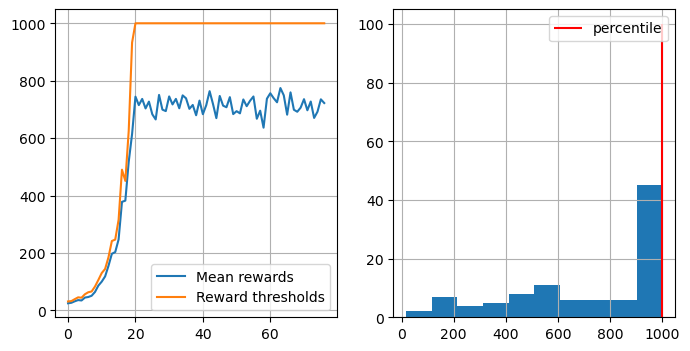

No elite samples this iteration. Skipping training.
mean reward = 745.800, threshold=1000.000


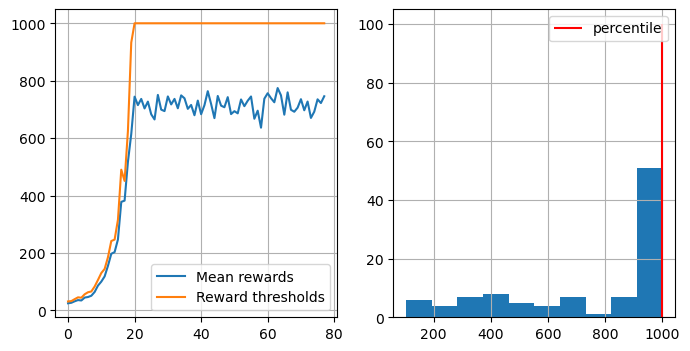

No elite samples this iteration. Skipping training.
mean reward = 709.580, threshold=1000.000


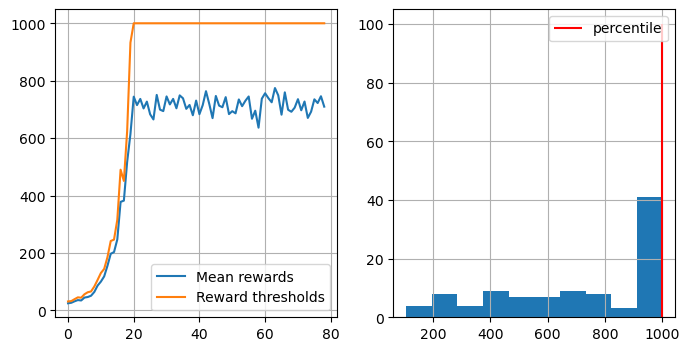

No elite samples this iteration. Skipping training.
mean reward = 737.620, threshold=1000.000


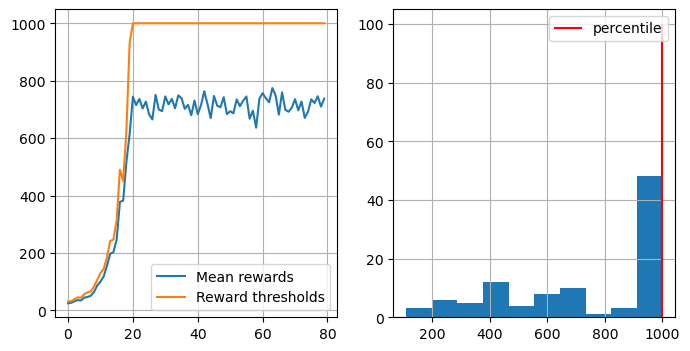

No elite samples this iteration. Skipping training.
mean reward = 733.320, threshold=1000.000


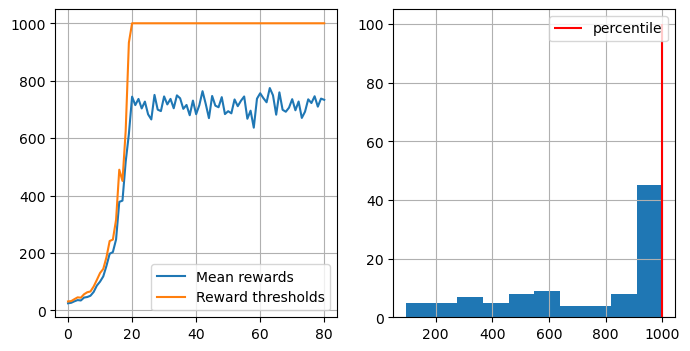

No elite samples this iteration. Skipping training.
mean reward = 691.020, threshold=1000.000


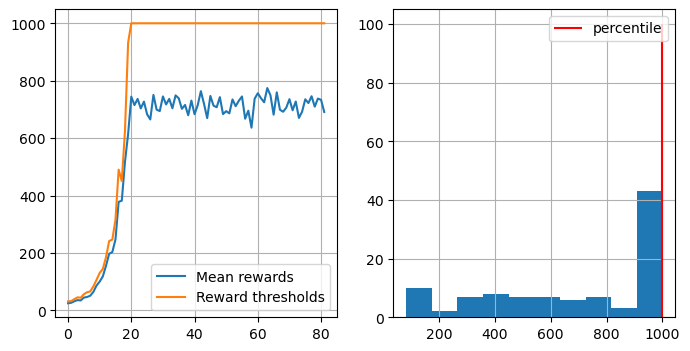

No elite samples this iteration. Skipping training.
mean reward = 745.580, threshold=1000.000


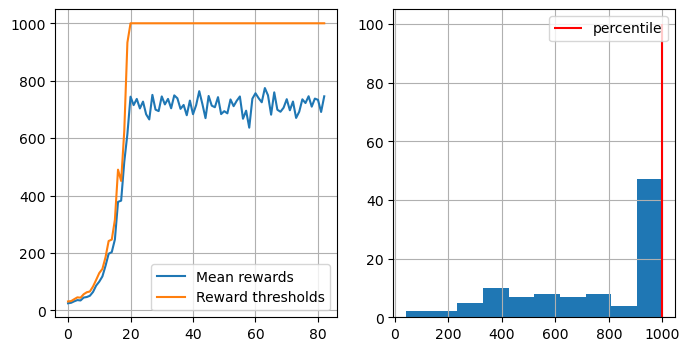

No elite samples this iteration. Skipping training.
mean reward = 676.860, threshold=1000.000


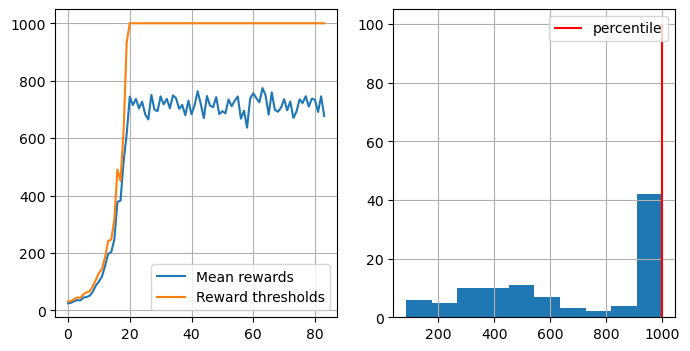

No elite samples this iteration. Skipping training.
mean reward = 705.300, threshold=1000.000


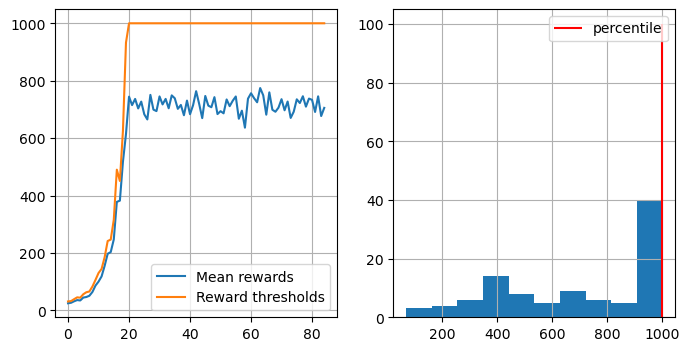

No elite samples this iteration. Skipping training.
mean reward = 689.980, threshold=1000.000


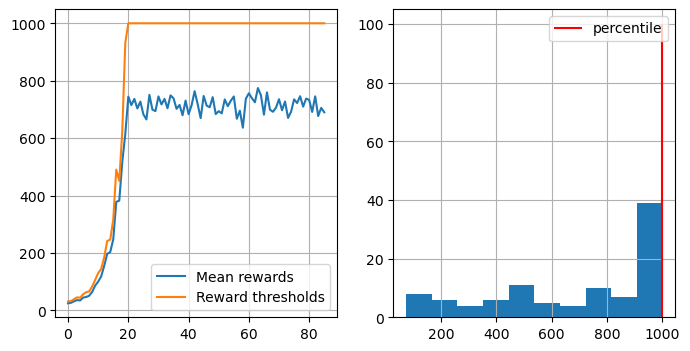

No elite samples this iteration. Skipping training.
mean reward = 710.060, threshold=1000.000


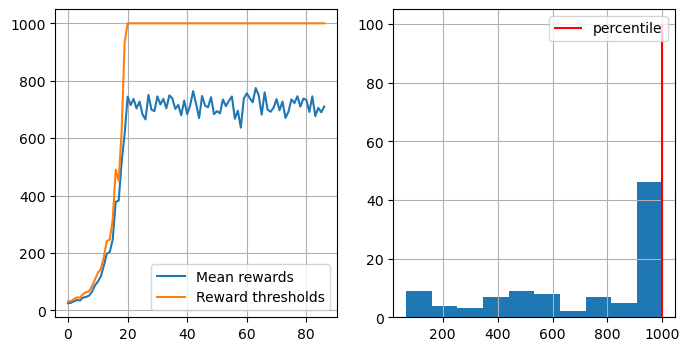

No elite samples this iteration. Skipping training.
mean reward = 737.070, threshold=1000.000


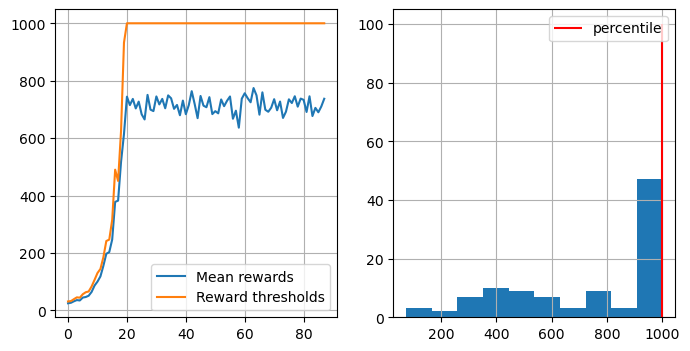

No elite samples this iteration. Skipping training.
mean reward = 690.040, threshold=1000.000


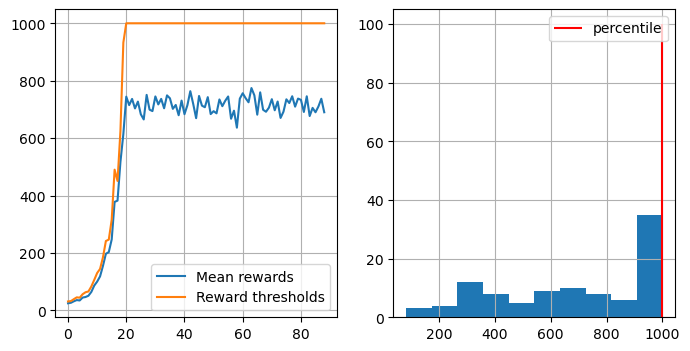

No elite samples this iteration. Skipping training.
mean reward = 728.880, threshold=1000.000


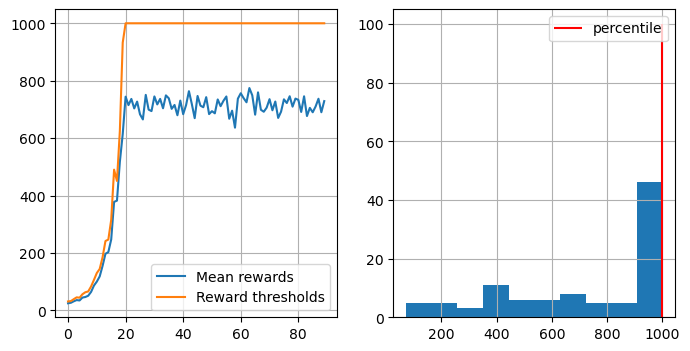

No elite samples this iteration. Skipping training.
mean reward = 705.630, threshold=1000.000


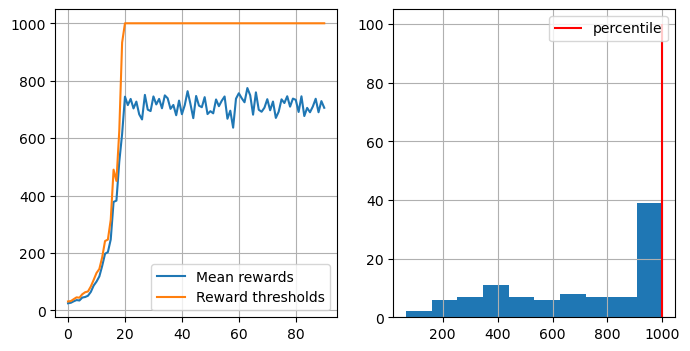

No elite samples this iteration. Skipping training.
mean reward = 718.770, threshold=1000.000


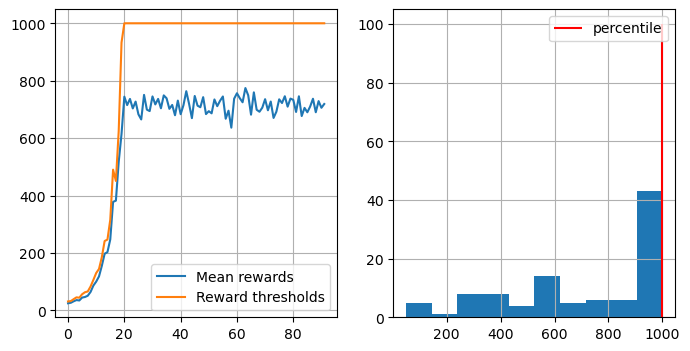

No elite samples this iteration. Skipping training.
mean reward = 728.440, threshold=1000.000


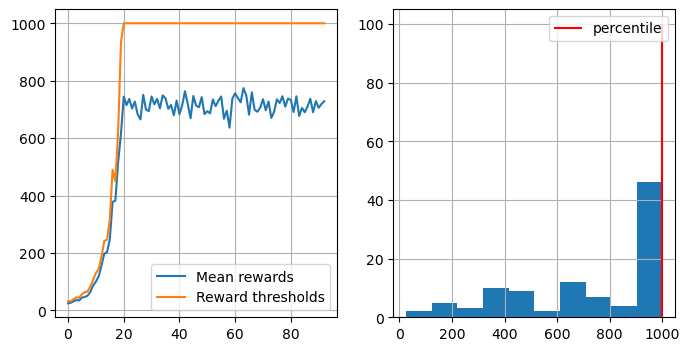

No elite samples this iteration. Skipping training.
mean reward = 721.550, threshold=1000.000


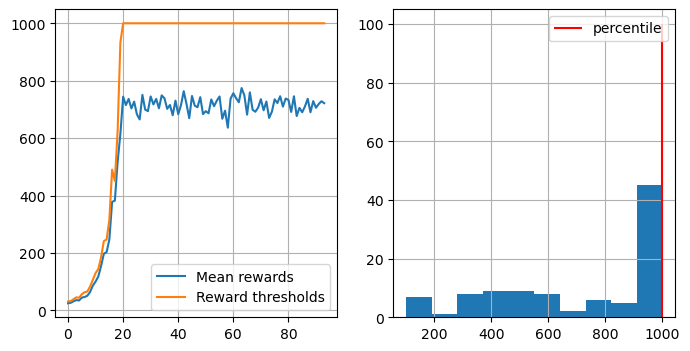

No elite samples this iteration. Skipping training.
mean reward = 758.400, threshold=1000.000


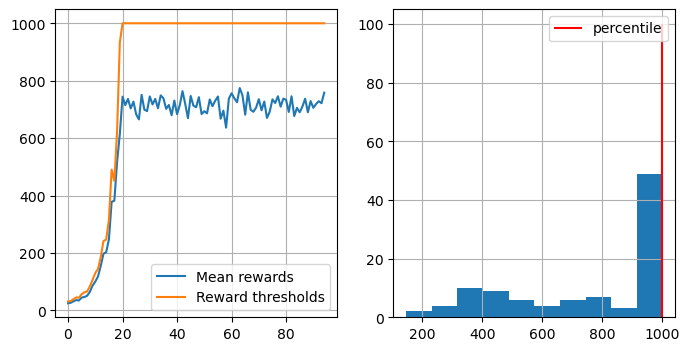

No elite samples this iteration. Skipping training.
mean reward = 730.080, threshold=1000.000


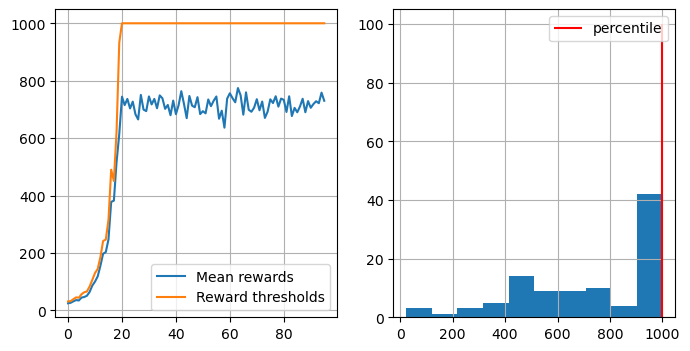

No elite samples this iteration. Skipping training.
mean reward = 762.360, threshold=1000.000


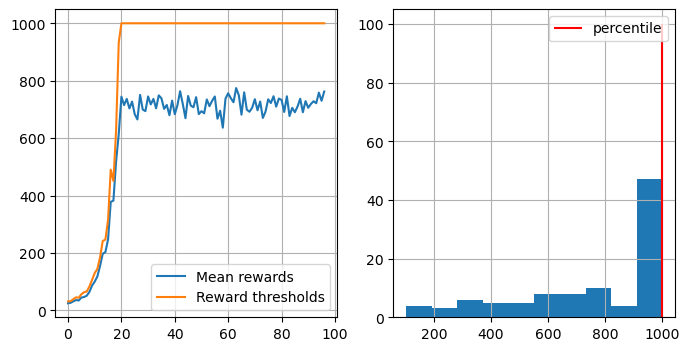

No elite samples this iteration. Skipping training.
mean reward = 728.630, threshold=1000.000


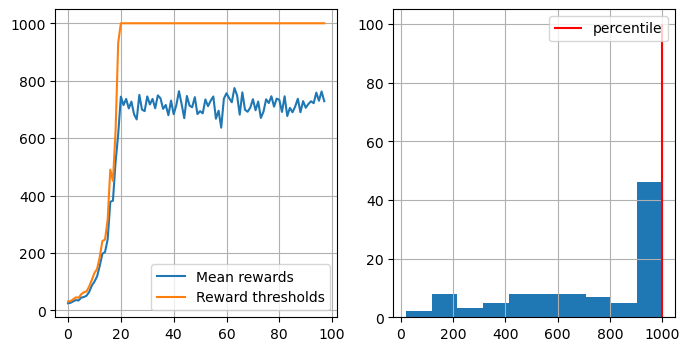

No elite samples this iteration. Skipping training.
mean reward = 715.780, threshold=1000.000


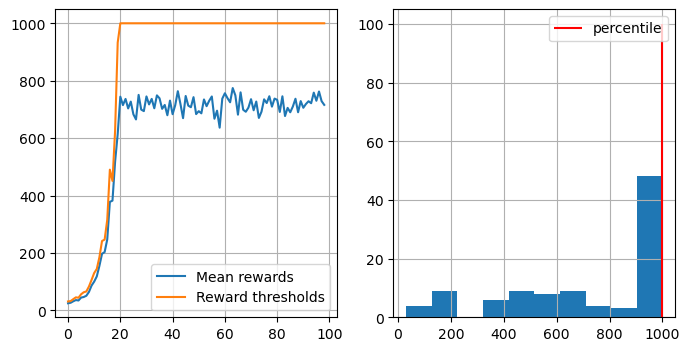

No elite samples this iteration. Skipping training.
mean reward = 735.070, threshold=1000.000


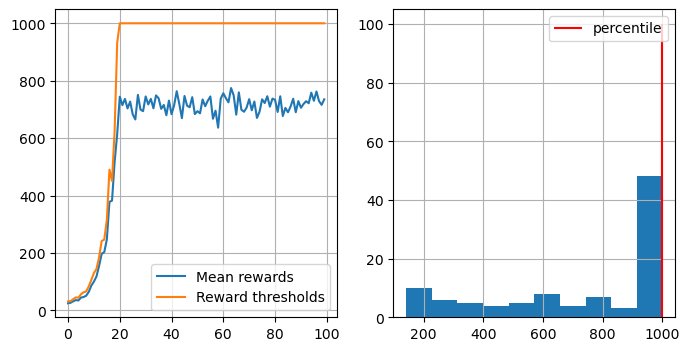

In [104]:
n_sessions = 100
percentile = 75
log = []

for i in range(100):
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    if len(elite_states) == 0 or len(elite_actions) == 0:
        print("No elite samples this iteration. Skipping training.")
        show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
        continue

    X = np.array(elite_states)
    y = np.array(elite_actions)

    assert len(X.shape) == 2, f"X must be 2D array, got shape {X.shape}"

    agent.partial_fit(X, y)
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [105]:

!pip install "gymnasium[other]"

In [106]:
from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

c:\Users\lutdi\miniconda3\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\lutdi\miniconda3\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\lutdi\Downloads\LabCNN\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [107]:
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]

if "google.colab" in sys.modules:
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(f"""
<video width="640" height="480" controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")

# Homework part I (Opitional)

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here>```

# Homework part II (Optional)

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling.
  * Try re-using samples from 3-5 last iterations when computing threshold and training.
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2`. Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [ ]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)
